# Proyecto final de imágenes
## EL5206-2 Laboratorio de inteligencia computacional y robótica
### **Integrantes:**
### Benjamín Castro
### Melanie Peña
### **Auxiliar:**
### Jorge Zambrano
### **Profesor:**
### Carlos Navarro



#### Imports de las librerías y archivos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
import skimage.feature as feature
import tensorflow
import pandas as pd
from pathlib import Path

# Se usa el modelo pre-entrenado VGG-16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

# Arregla el error de la función imshow (en caso que sea necesaria)
from google.colab.patches import cv2_imshow

### Como alternativa, puede conectarse a Google Drive. Añada a su unidad una carpeta llamada 'JPG'. Ese será su espacio de trabajo al momento de ejecutar el buscador.

In [2]:
# Descomentar si quiere usar Drive
#from google.colab import drive
#drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
#cd /content/drive/MyDrive/JPG/

/content/drive/MyDrive/JPG


### Si no encuentra los archivos tar.gz, los descarga directamente (puede tardar un poco)

In [4]:
# JPG1
if not Path("./jpg1.tar.gz").is_file():
  !wget "ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg1.tar.gz"

In [5]:
# JPG2
if not Path("jpg2.tar.gz").is_file():
  !wget "ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg2.tar.gz"

In [ ]:
# Extrae los archivos tar.gz
!tar -xf jpg1.tar.gz
!tar -xf jpg2.tar.gz 

### 1. *Feature Extraction*

#### CNN

In [6]:
# Extracción con VGG-16
model = VGG16(weights='imagenet',include_top=False)

def feat_cnn(net,img):
  """ Toma el modelo con el cual predecir y la ID la imagen en string,
  devuelve el vector de características """
  assert type(img) == str,'Entregue el nombre de la consulta en string'
  path = './jpg/'+img+'.jpg' # Ruta de acceso de la base de datos
  img_loaded = image.load_img(path, target_size = (224,224))
  x = image.img_to_array(img_loaded)
  x = np.expand_dims(x,axis=0)
  x = preprocess_input(x)
  feat = net.predict(x)
  return feat

58889256/58889256 [==============================] - 0s 0us/step


#### LBP 

In [7]:
def feat_lbp(img):
  """ Toma la ID de imagen en string, devuelve el vector de características"""
  assert type(img) == str,'Entregue el nombre de la consulta en string'
  path = './jpg/'+img+'.jpg' # Ruta de acceso de la base de datos
  img_loaded = image.load_img(path, color_mode = "grayscale", target_size = (224,224))
  # Cantidad de píxeles de radio a considerar
  r = 1
  p = 8
  lbp_img = feature.local_binary_pattern(img_loaded, P = p, R = r)
  (hist, _) = np.histogram(lbp_img.ravel(), bins = np.arange(0, 84), range = (0,255))

  # Normalización
  hist = hist.astype("float")
  hist /= (hist.sum() + 1e-6)
  
  return hist


In [8]:
def feat_extract(img,ext):
  """ Toma dos strings: nombre de la imagen y tipo de extracción,
  se puede escoger clásico o usando CNN"""
  assert type(img) == str,'Entregue el nombre de la consulta en string'
  assert ext == 'classic' or ext == 'cnn','Puede escoger solo cnn o classic'
  if ext == 'classic':
    return feat_lbp(img)
  if ext == 'cnn':
    return feat_cnn(model,img)

### 2. Medida de similitud

In [9]:
def cos_dist(x1,x2):
  """ Toma la distancia entre 2 vectores """
  norm1 = np.linalg.norm(x1)
  norm2 = np.linalg.norm(x2)
  if norm1 == 0.0 or norm2 == 0.0:
    return np.inf
  else:
    num = np.sum(x1*x2)
    den = np.sqrt(norm1)*np.sqrt(norm2)
    return num/den

In [10]:
def euclidean(x1,x2):
  return np.linalg.norm((x1-x2))

#### Guardar las características de cada imagen de la base de datos 

##### Imágenes de consulta

In [11]:
def numtostr(num,dig):
  ''' Función que pasa de un entero a string dependiendo de 
  si se trata de ID (2 dig.) oclase (3 dig.) '''
  assert type(num) is int,'Ingrese un valor entero'
  # Func. auxiliar que retorna el valor entero con cierta ctdad de ceros
  def entero(num,nozeros=0):
    return nozeros*'0' + str(num)
  num = abs(num)
  if dig == 'ID':
    if num in range(0,10):
      return entero(num,1)
    else:
      return entero(num)
  if dig == 'class':
    if num in range(0,10):
      return entero(num,2)
    if num in range(10,100):
      return entero(num,1)
    else:
      return entero(num)


In [12]:
# Lista con nombres de imágenes de consulta:
path_query = ['1'+numtostr(n,'class')+'00' for n in range(0,500)]

##### Imágenes base de datos

In [13]:
# Almacena los nombres de las imagenes de las bases de datos
path_db = []
for i in range(0,500):
  for j in range(1,11):
    # Revisa si existe el archivo con ese nombre
    path = '1'+numtostr(i,'class')+numtostr(j,'ID')
    if Path("./jpg/"+path+'.jpg').is_file():
      path_db.append(path) # Lo guarda

### SI TIENE LOS ARCHIVOS .npy, NO EJECUTAR 

In [ ]:
# Vectores característicos de imágenes de consulta 
# se almacenan en la lista
query_cnn = []
query_classic = []
for i in range(0,500):
  query_cnn.append(feat_extract(path_query[i],'cnn'))
  query_classic.append(feat_extract(path_query[i],'classic'))

1/1 [==============================] - 0s 430ms/step


In [ ]:
# La información se guarda en diccionarios para consultar
query_cnn_DB = dict(zip(path_query,query_cnn))
query_classic_DB = dict(zip(path_query,query_classic)) 

In [ ]:
# Guarda en archivos npy los vectores característicos
np.save('q_cnn.npy', query_cnn_DB)
np.save('q_classic.npy', query_classic_DB)

In [ ]:
db_cnn = []
db_classic = []
for path in path_db:
  db_cnn.append(feat_extract(path,'cnn'))
  db_classic.append(feat_extract(path,'classic'))

1/1 [==============================] - 0s 406ms/step


In [ ]:
# La información se guarda en diccionarios para consultar
db_cnn_dict = dict(zip(path_db,db_cnn))
db_classic_dict = dict(zip(path_db,db_classic)) 

In [ ]:
# Guarda en archivos npy los vectores característicos
np.save('db_cnn.npy', db_cnn_dict)
np.save('db_classic.npy', db_classic_dict)

### 3. Ordenar resultados por relevancia

#### Carga de diccionarios (necesita los archivos .npy, los puede descargar en los .zip correspondientes)

In [15]:
query_cnn_DB = np.load('q_cnn.npy',allow_pickle = True, )
query_classic_DB = np.load('q_classic.npy',allow_pickle = True)

In [16]:
db_cnn_dict = np.load('db_cnn.npy',allow_pickle = True)
db_classic_dict = np.load('db_classic.npy',allow_pickle = True)

### Función que calcula distancias con respecto a la imagen *query*

In [60]:
def distances(img,mode):
  ''' Toma el string de la imagen de consulta y calcula las
  distancias con respecto a los features de la base de datos 
  (diccionario 'data') '''
  assert type(img) is str and img in path_query and type(mode) is str,'Ingrese el nombre\
  de una imagen de consulta (string) y un modo válido'
  dist = []
  if mode == 'cnn':
    for path in path_db:
      # Calcula la distancia euclideana entre los vectores de feature
      query = query_cnn_DB.item().get(img)
      database = db_cnn_dict.item().get(path) 
      d = euclidean(query,database)
      dist.append(d)
  if mode == 'classic':
    for path in path_db:
      query = query_classic_DB.item().get(img)
      database = db_classic_dict.item().get(path) 
      d = euclidean(query,database)
      dist.append(d)
  # DataFrame que almacena las distancias de los feature
  df = pd.DataFrame()
  df['Image'] = path_db
  df['Distance'] = dist
  df.sort_values(by = ['Distance'], ascending = True, inplace=True)
  df = df.reset_index(drop=True)
  return df


In [61]:
distances('100100','classic')

,Image,Distance
0,100101,0.009694
1,134502,0.016049
2,102302,0.018900
3,103101,0.019727
4,103901,0.019727
...,...,...
983,126701,0.160994
984,126705,0.161697
985,130201,0.174284
986,149901,0.187046


In [18]:
# Imágenes de la misma clase
# compara por el nombre
def nrel(img):
  """ Busca cantidad de imágenes por clase """
  i = 0
  for image in path_db:
    if image[0:4] == img[0:4]: # Tienen la misma clase
      i +=1
  return i

In [19]:
def ranking(img,mode):
  """Función de ranking para medir desempeño"""
  assert type(img) == str and img in path_query, 'Ingrese un nombre de imagen valido'
  dist = distances(img,mode) # Saca el dataframe con el ranking por relevancia
  dist = dist.loc[:,['Image']]
  dist = dist[dist['Image'].str[0:4] == img[0:4]]
  rank = sum(dist.index.tolist())/nrel(img)
  return rank

In [20]:
def rank_norm(img,mode):
  """ Función de ranking normalizado """
  assert type(img) == str and img in path_query, 'Ingrese un nombre de imagen valido'
  dist = distances(img,mode) # Saca el dataframe con el ranking por relevancia
  dist = dist.loc[:,['Image']] 
  N = dist['Image'].count()
  Nrel = nrel(img)
  dist = dist[dist['Image'].str[0:4] == img[0:4]]
  ind = dist.index.tolist()
  idx = [index for index in ind] 
  return (sum(idx) - Nrel*(Nrel+1)/2)*(1/(N*Nrel))

In [39]:
# Ranking normalizado promedio 

# Clásico
rank_n_classic = sum([rank_norm(img,'classic') for img in path_query])/len(path_query)

# CNN
rank_n_cnn = sum([rank_norm(img,'cnn') for img in path_query])/len(path_query)
print(f'Ranking normalizado para modo clásico:{rank_n_classic}')
print(f'Ranking normalizado para modo CNN:{rank_n_cnn}')

Ranking normalizado para modo clásico:0.15011024355761193
Ranking normalizado para modo CNN:0.22059468784139835


In [40]:
std_classic = np.std([rank_norm(img,'classic') for img in path_query])
std_cnn = np.std([rank_norm(img,'cnn') for img in path_query])
print(f'Desv. estándar classic: {std_classic}')
print(f'Desv. estándar cnn: {std_cnn}')

Desv. estándar classic: 0.19749559590660482
Desv. estándar cnn: 0.2553100125304266


In [33]:
def results(img,mode):
  """ Resultados de búsqueda """
  assert type(img) == str and img in path_query, 'Ingrese un nombre de imagen valido'
  dist = distances(img,mode)[0:10]
  dist = dist.loc[:,['Image']].to_numpy()
  for path in dist:
    path = './jpg/'+str(path[0])+'.jpg' # Ruta de acceso de la base de datos
    image = cv2.imread(path)
    image = cv2.resize(image,(224,224))
    cv2_imshow(image)


### Medición de tiempo sin optimización

In [58]:
import timeit
# Modo cnn
%timeit distances('134600','cnn')

62.4 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [59]:
# Modo cnn
%timeit distances('134600','classic')

26.4 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Ejemplo de Búsqueda

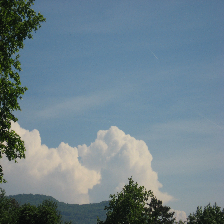

In [41]:
i = cv2.imread('./jpg/134600.jpg')
i = cv2.resize(i,(224,224))
cv2_imshow(i)

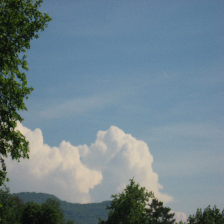

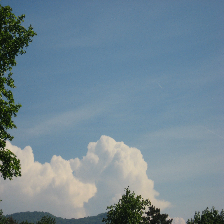

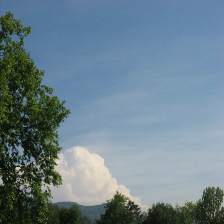

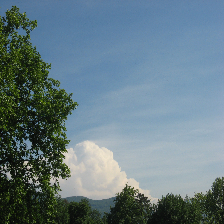

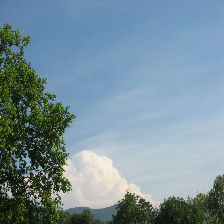

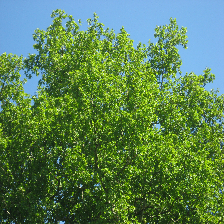

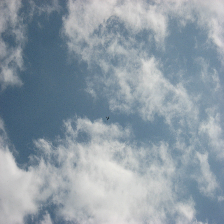

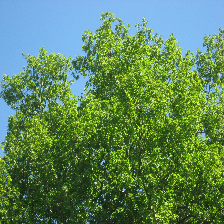

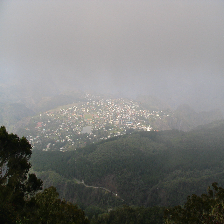

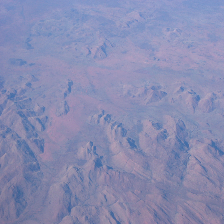

In [42]:
results('134600','cnn')

### Reducción de dimensionalidades

#### PCA vanilla

In [65]:
# Import de PCA
from sklearn.decomposition import PCA

# Conjuntos para guardar vectores característicos en bases de datos
X_cnn = []
X_classic = []

# Almacena vectores característicos
for path in path_db:
  db_cnn_img = db_cnn_dict.item().get(path)
  db_classic_img = db_classic_dict.item().get(path)
  X_cnn.append(db_cnn_img)
  X_classic.append(db_classic_img)


In [66]:
# Almacenar vectores característicos de query
y_cnn = []
y_classic = []
for path in path_query:
  query_cnn_img = query_cnn_DB.item().get(path)
  query_classic_img = query_classic_DB.item().get(path)
  y_cnn.append(query_cnn_img)
  y_classic.append(query_classic_img)

In [67]:
# Pasa conjunto de query a array para operar y procesar
y_cnn = np.array(y_cnn)
y_cnn = np.reshape(y_cnn,(500,25088)) # Comprime features de cnn
y_classic = np.array(y_classic)

In [68]:
# Conjunto de bdd a array
X_cnn = np.array(X_cnn)
X_cnn = np.reshape(X_cnn,(988,25088))

In [69]:
# Uso de modelo PCA (cada modelo se ajusta a un conjunto distinto)
# Objetivo: reducir a dimensión 2 el esp. de vectores característicos 
pca = PCA(n_components=2)
X_cnn_pca = pca.fit_transform(X_cnn)
X_classic = np.array(X_classic)
X_classic_pca = pca.fit_transform(X_classic)

In [70]:
y_cnn_pca = pca.fit_transform(y_cnn)
y_classic_pca = pca.fit_transform(y_classic)

### Redefinición de distancias con nuevo *dataset* comprimido

In [71]:
def distances_opt_pca(img,mode):
  ''' Toma la imagen de query y calcula la distancia euclideana con respecto a 
  la base de datos en el espacio con las nuevas dimensiones '''
  assert type(img) is str and img in path_query and type(mode) is str,'Ingrese el nombre\
  de una imagen de consulta (string) y un modo válido'
  dist = []
  i = path_query.index(img)
  if mode == 'cnn':
    for data in X_cnn_pca:
      d = euclidean(y_cnn_pca[i],data)
      dist.append(d)
  if mode == 'classic':
    for data in X_classic_pca:
      d = euclidean(y_classic_pca[i],data)
      dist.append(d)
  # DataFrame que almacena las distancias de los feature
  df = pd.DataFrame()
  df['Image'] = path_db
  df['Distance'] = dist
  df.sort_values(by = ['Distance'], ascending = True, inplace=True)
  df = df.reset_index(drop=True)
  return df


In [72]:
def rank_norm_opt(img,mode,distancias=distances_opt_pca):
  """ Redefinición del ranking normalizado """
  assert type(img) == str and img in path_query, 'Ingrese un nombre de imagen valido'
  dist = distancias(img,mode) # Saca el dataframe con el ranking por relevancia
  dist = dist.loc[:,['Image']] 
  N = dist['Image'].count()
  Nrel = nrel(img)
  dist = dist[dist['Image'].str[0:4] == img[0:4]]
  ind = dist.index.tolist()
  idx = [index for index in ind] 
  return (sum(idx) - (Nrel*(Nrel+1))/2) *(1/(N*Nrel))

In [73]:
# Ranking normalizado promedio PCA

# Clásico
rank_n_classic_pca = sum([rank_norm_opt(img,'classic') for img in path_query])/len(path_query)


# CNN
rank_n_cnn_pca = sum([rank_norm_opt(img,'cnn') for img in path_query])/len(path_query)

print(f'Ranking normalizado PCA Vanilla para modo clásico:{rank_n_classic_pca}')


print(f'Ranking normalizado PCA Vanilla para modo CNN:{rank_n_cnn_pca}')


Ranking normalizado PCA Vanilla para modo clásico:0.1900048486601117
Ranking normalizado PCA Vanilla para modo CNN:0.12397824689929961


In [74]:
# Desviación estándar para clasificación

std_classic_pca = np.std([rank_norm_opt(img,'classic') for img in path_query])
std_cnn_pca = np.std([rank_norm_opt(img,'cnn') for img in path_query])
print(f'Desv. estándar classic: {std_classic_pca}')
print(f'Desv. estándar cnn: {std_cnn_pca}')

Desv. estándar classic: 0.1987771851562741
Desv. estándar cnn: 0.12017062790428723


In [53]:
# Redefinición de función de resultados

def results_opt(img,mode):
  assert type(img) == str and img in path_query, 'Ingrese un nombre de imagen valido'
  dist = distances_opt_pca(img,mode)[0:10]
  dist = dist.loc[:,['Image']].to_numpy()
  for path in dist:
    path = './jpg/'+str(path[0])+'.jpg' # Ruta de acceso de la base de datos
    image = cv2.imread(path)
    image = cv2.resize(image,(224,224))
    cv2_imshow(image)

### Medición de tiempo de algoritmo con optimización

In [49]:
# Modo classic
%timeit distances_opt_pca('111400','classic')

9.28 ms ± 786 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [50]:
# Modo cnn
%timeit distances_opt_pca('111400','cnn')

10.5 ms ± 2.41 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Resultados de prueba

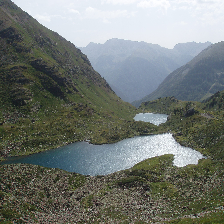

In [51]:
i = cv2.imread('./jpg/111400.jpg')
i = cv2.resize(i,(224,224))
cv2_imshow(i)

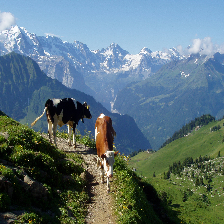

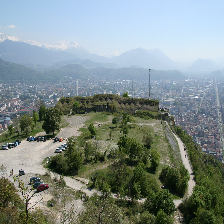

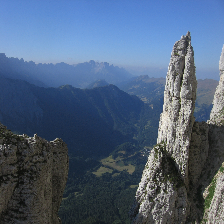

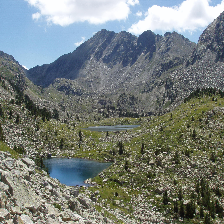

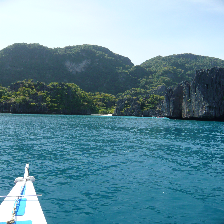

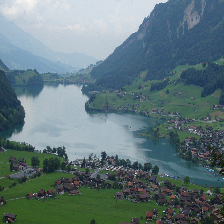

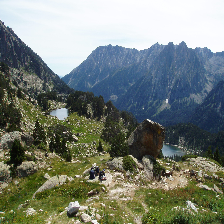

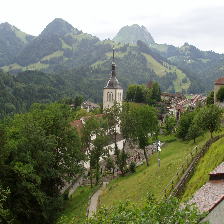

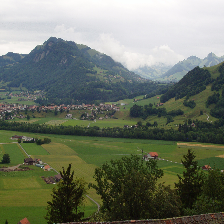

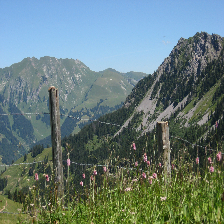

In [56]:
results_opt('111400','cnn')